In [1]:
import numpy as np
import torch
from torch_geometric.data import Data
device = torch.device('cuda')

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long, device=device)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float, device=device)

data = Data(x=x, edge_index=edge_index, device=device)

In [1]:
# https://github.com/pyg-team/pytorch_geometric/tree/master/examples
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, Linear

class GCN(torch.nn.Module):
    def __init__(self, nodewise_output=False):
        """
        :param num_outputs: if False (default): no pooling is performed (node regression). Otherwise, we pool the whole graph
        """
        super().__init__()
        num_hidden_units = 16
        self.conv1 = GCNConv(dataset.num_node_features, num_hidden_units)
        self.conv2 = GCNConv(num_hidden_units, dataset.num_classes if nodewise_output else num_hidden_units)
        if nodewise_output:
            self.fc1 = Linear(num_hidden_units, dataset.num_classes)
        self.nodewise_output = nodewise_output

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        if self.nodewise_output:
            return F.log_softmax(x, dim=1) # Note that this layer is designed for classification
        x = global_mean_pool(x, x.batch) # x.batch is used to only average about nodes in the same batch
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        return F.log_softmax(x, dim=1)



In [14]:
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader

# Only 1 graph -> needs train/test/validation masks
# dataset = Planetoid(root='/tmp/Cora', name='Cora')

# multiple graphs -> just split them in train/test/val
# classification -> needs final pooling layer
# dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')
dataset = TUDataset(root='/tmp/MUTAG', name='MUTAG')

print(dataset)
print(dataset[0])
print(dataset.num_classes)

MUTAG(188)
Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
2


In [37]:
import torch
from torch_geometric.data import Data
device = torch.device('cuda')

import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, Linear

class MyGNN(torch.nn.Module):
    def __init__(self, dataset, layer_sizes=[16, 16, 16, 16]):
        super().__init__()

        layer_sizes = [dataset.num_node_features] + layer_sizes
        convs = []
        for i in range(len(layer_sizes) - 1):
            convs.append(GCNConv(layer_sizes[i], layer_sizes[i+1]))

        self.convs = torch.nn.ModuleList(convs)
        self.final = Linear(layer_sizes[-1], dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            # x = F.dropout(x, training=self.training)

        # for i in range(data.edge_index.shape[1]):
        #     print(data.edge_index[:, i])



        x = global_mean_pool(x, data.batch) # x.batch is used to only average about nodes in the same batch
        return F.log_softmax(self.final(x), dim=1)
        # x = F.dropout(x, training=self.training)

#model = GCN(nodewise_output=False).to(device)
model = MyGNN(dataset).to(device)

dataset = dataset.shuffle()
train_percentage = 0.8
test_percentage = 0.1
valid_percentage = 0.1
test_start = int(train_percentage * len(dataset))
valid_start = int((train_percentage + test_percentage) * len(dataset))
train_data = dataset[:test_start - 1]
test_data = dataset[test_start:valid_start - 1]
valid_data = dataset[valid_start:]
loader = DataLoader(train_data, batch_size=64, shuffle=True)
print(train_data, test_data, valid_data)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(500):
    for data in loader:
        data = data.to(device) # TODO seems hella inefficient
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()


model.eval()
# OBVIOUSLY SHADY BUT OTHERWISE VALID WOULD BE TOO SMALL:
#valid_data = dataset
valid_loader = DataLoader(valid_data, batch_size=64)
correct = 0
for data in valid_loader:
    pred = model(data.to(device)).argmax(dim=1)
    correct += (pred == data.y).sum()
samples = len(valid_data)
acc = correct / samples
print(f'Accuracy: {acc:.4f} ({correct} of {samples} correct)')

MUTAG(149) MUTAG(18) MUTAG(19)
tensor([0, 1], device='cuda:0')
tensor([0, 5], device='cuda:0')
tensor([1, 0], device='cuda:0')
tensor([1, 2], device='cuda:0')
tensor([2, 1], device='cuda:0')
tensor([2, 3], device='cuda:0')
tensor([ 2, 12], device='cuda:0')
tensor([3, 2], device='cuda:0')
tensor([3, 4], device='cuda:0')
tensor([3, 9], device='cuda:0')
tensor([4, 3], device='cuda:0')
tensor([4, 5], device='cuda:0')
tensor([5, 0], device='cuda:0')
tensor([5, 4], device='cuda:0')
tensor([5, 6], device='cuda:0')
tensor([6, 5], device='cuda:0')
tensor([6, 7], device='cuda:0')
tensor([6, 8], device='cuda:0')
tensor([7, 6], device='cuda:0')
tensor([8, 6], device='cuda:0')
tensor([9, 3], device='cuda:0')
tensor([ 9, 10], device='cuda:0')
tensor([ 9, 11], device='cuda:0')
tensor([10,  9], device='cuda:0')
tensor([11,  9], device='cuda:0')
tensor([12,  2], device='cuda:0')
tensor([13, 14], device='cuda:0')
tensor([13, 18], device='cuda:0')
tensor([14, 13], device='cuda:0')
tensor([14, 15], device

KeyboardInterrupt: 

In [9]:
# Train single graph
model = GCN().to(device)
data = dataset[0].to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data.to(device))
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [16]:
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

AttributeError: 'GlobalStorage' object has no attribute 'test_mask'

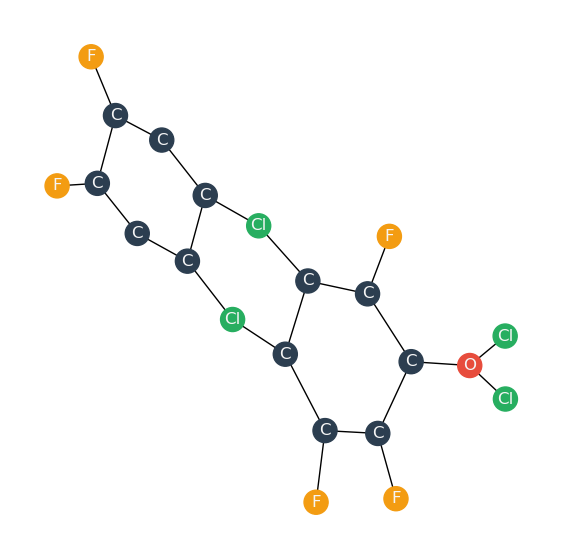

tensor([0])


In [31]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def draw_mutag(data, wandb=False):
    ATOM_MAP = np.array(['C', 'O', 'Cl', 'H', 'N', 'F',
                'Br', 'S', 'P', 'I', 'Na', 'K', 'Li', 'Ca'])
    COLOR_MAP = np.array(['#2c3e50', '#e74c3c', '#27ae60', '#3498db', '#CDDC39', '#f39c12',
                '#795548', '#8e44ad', '#3F51B5', '#7f8c8d', '#e84393', '#607D8B', '#8e44ad', '#009688'])
    fig, ax = plt.subplots(figsize=(7,7))
    ax.axis('off')

    x = data.x.numpy()
    num_from_onehot = np.sum(x * np.arange(x.shape[1])[None, :], 1).astype(int)

    G = to_networkx(data, to_undirected=True)

    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=1), labels=dict(enumerate(ATOM_MAP[num_from_onehot])),
                     node_color=COLOR_MAP[num_from_onehot], font_color="whitesmoke")
    if wandb:
        return wandb.Image(plt)
    else:
        plt.show()

i = 6
draw_mutag(dataset[i])
print(dataset[i].y)

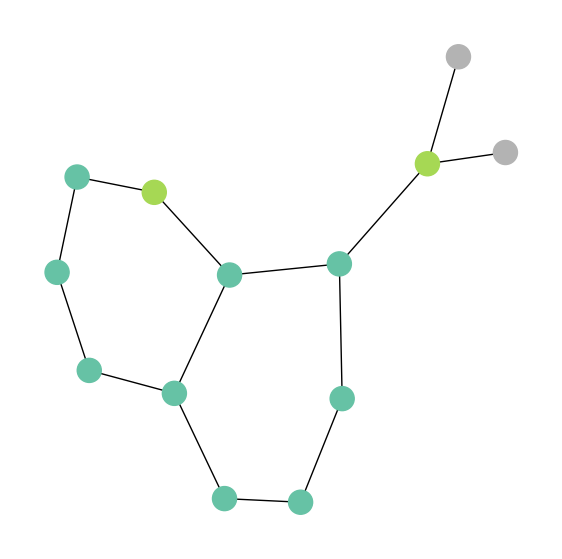

In [8]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import wandb

def draw_graph(data, color, wandb=False):
    fig, ax = plt.subplots(figsize=(7,7))
    ax.axis('off')
    G = to_networkx(data, to_undirected=True)
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=1), with_labels=False,
                     node_color=color, cmap="Set2")
    if wandb:
        return wandb.Image(plt)
    else:
        plt.show()

graph_index = 1 # which graph of the dataset to show
if dataset[graph_index].y.shape[0] == dataset[graph_index].x.shape[0]:
    # we can use dataset[0].y as colors if the labels are node-wise
    color = dataset[0].y
else:
    # Otherwise we assume one-hot features and use them
    color = torch.sum(dataset[graph_index].x * np.arange(dataset[graph_index].x.shape[1])[None, :], 1)

draw_graph(dataset[graph_index], color)

In [7]:
%wandb

UsageError: Line magic function `%wandb` not found.


In [ ]:
import wandb
wandb.init(project="MPhil-project", entity="jonas-juerss")
wandb.log

/home/jonas/anaconda3/envs/mphil/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


tensor([[0.9300, 0.0800, 0.0900],
        [0.8600, 0.1300, 0.1800],
        [0.8800, 0.1200, 0.1900],
        [0.1400, 0.1000, 0.9300],
        [0.2300, 0.9300, 0.0900],
        [0.0700, 0.8600, 0.1300],
        [0.1300, 0.9100, 0.0800],
        [0.1000, 0.8600, 0.0700],
        [0.9000, 0.3300, 0.1200],
        [0.8100, 0.0900, 0.1900],
        [0.8900, 0.1000, 0.1900]], dtype=torch.float64)


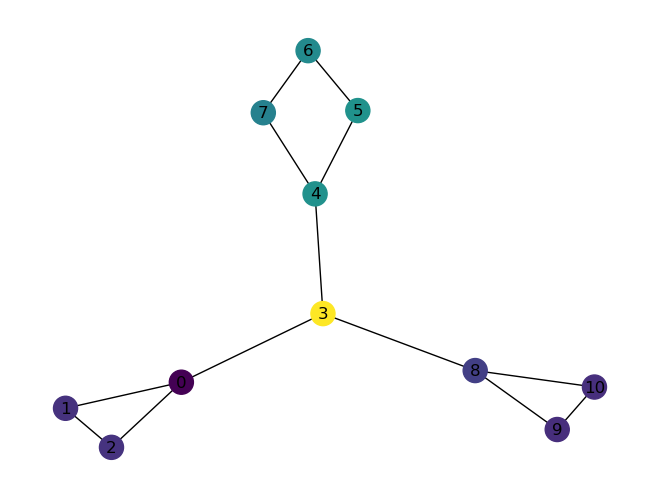

In [4]:
import torch
from torch_geometric.data import Data
import torch_geometric
import numpy as np
import networkx as nx

nodes = torch.tensor([[1, 0, 0],
                     [1, 0, 0],
                     [1, 0, 0],
                     [0, 0, 1],
                     [0, 1, 0],
                     [0, 1, 0],
                     [0, 1, 0],
                     [0, 1, 0],
                     [1, 0, 0],
                     [1, 0, 0],
                     [1, 0, 0]], dtype=float)

noise = torch.randn(nodes.shape)
nodes = torch.nn.functional.sigmoid(nodes * 4 - 2  + 0.5 * noise)
# nodes = torch.nn.functional.softmax(nodes * 4 - 2 + noise, dim=1)
# TODO make more realistic/get rid of negatives with softmax

edge_index = torch.tensor([[0, 1, 2, 0, 3, 4, 5, 6, 7, 3, 8, 9, 10],
                           [1, 2, 0, 3, 4, 5, 6, 7, 4, 8, 9, 10, 8]], dtype=torch.long)
edge_index_both = torch.cat((edge_index, edge_index[[1, 0], :]), dim=1) # includes both directions. Apparently, that's what torch wants but I don't

data = Data(x=nodes, y=nodes, edge_index=edge_index_both)
color = torch.sum(nodes * np.arange(nodes.shape[1])[None, :], dim=1)
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, node_color=color, pos=nx.spring_layout(g, seed=1), with_labels=True)

#draw_mutag(data)

print(np.round(nodes, 2))

In [ ]:
# fc = torch.nn.Linear(nodes.shape[1])
for edge in edge_index:
    # "Probability" they are the same
    prob = 1 - torch.nn.functional.tanh(torch.sum(torch.square(nodes[edge[0], :] - nodes[edge[1], :])))
    torch.distributions.Bernoulli(prob).sample()

In [ ]:
q_table = torch.zeros((nodes.shape[0] * nodes.shape[1], 2))
# TODO, not order invariant yet (which nodes comes first) but that can easily be attained e.g. by sorting them

for edge in edge_index:
    if torch.rand() < 0.1:
        action = torch.randint(2)
    else:
        # Look up sampling again: I think I don't really want to LEARN the probability here, so how would that be done? Otherwise look at RL mit continuous input
        concepts = torch.distributions.Bernoulli(nodes[edge, :]) # sample 1-hot vector (2, num_features) representing both concepts





Note:
- I can give the negative loss of the subsequent layer as reward
- if RL works, then maybe I can also get rid of it because I have some way to differentiably perform the discrete action. I don't really need to LEARN edge pruning, I can just do it based on node similarity
- [RL](https://medium.com/analytics-vidhya/a-beginners-guide-to-reinforcement-learning-and-its-basic-implementation-from-scratch-2c0b5444cc49)

In [16]:
edge_probabilities = torch.tanh(torch.sqrt(torch.sum((nodes[edge_index[0, :]] - nodes[edge_index[1, :]]) ** 2, axis=1)))

In [10]:
import torch